In [1]:
# Data manipulation and plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# SARIMAX from statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX

# For splitting data and error metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# For statistical tests
import statsmodels.api as sm
import math


             humidity  solar_irradiance  temperature  energy_production
date                                                                   
2022-01-01  62.483571        519.584526    19.584632          45.939761
2022-01-02  59.653418        407.333812    16.585660          51.806938
2022-01-03  63.927819        551.165919    19.889962          65.616643
2022-01-04  68.648958        345.248763    18.223795          38.991621
2022-01-05  60.207166        623.584561    19.291879          60.911264


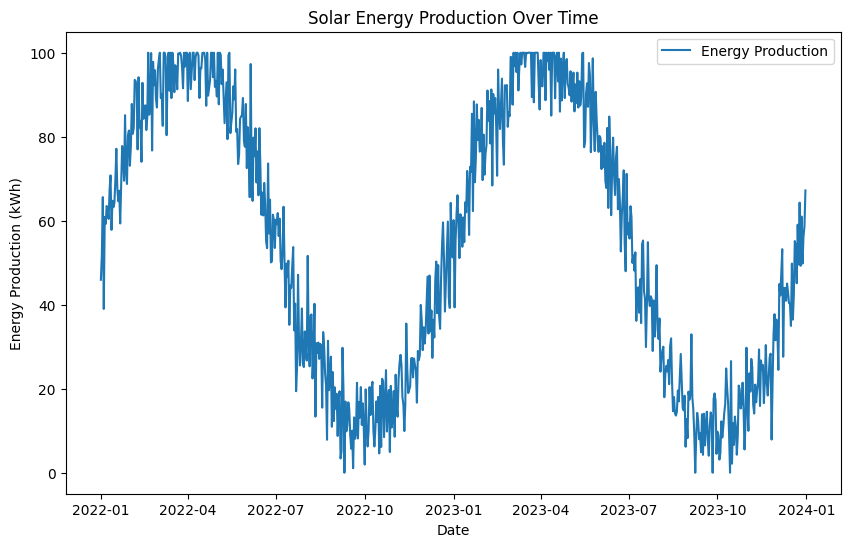

In [2]:
# Load your dataset with the correct column names and parse dates
data = pd.read_csv('solar_power_data.csv', parse_dates=['date'], index_col='date')

# Visualize the first few rows of the data
print(data.head())

# Plot the solar energy production over time
plt.figure(figsize=(10,6))
plt.plot(data.index, data['energy_production'], label='Energy Production')
plt.xlabel('Date')
plt.ylabel('Energy Production (kWh)')
plt.title('Solar Energy Production Over Time')
plt.legend()
plt.show()


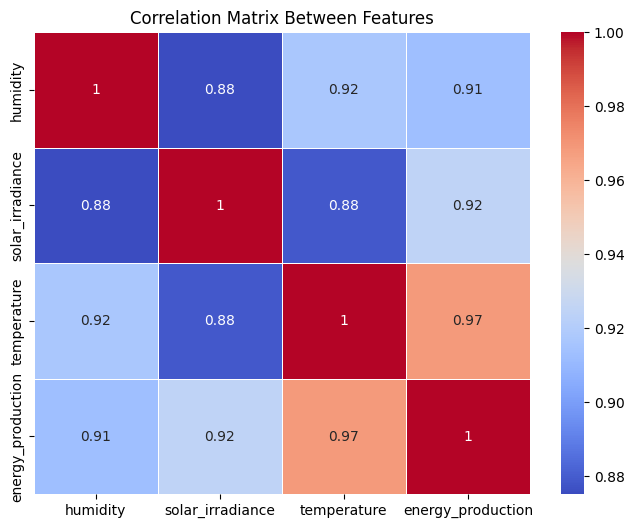

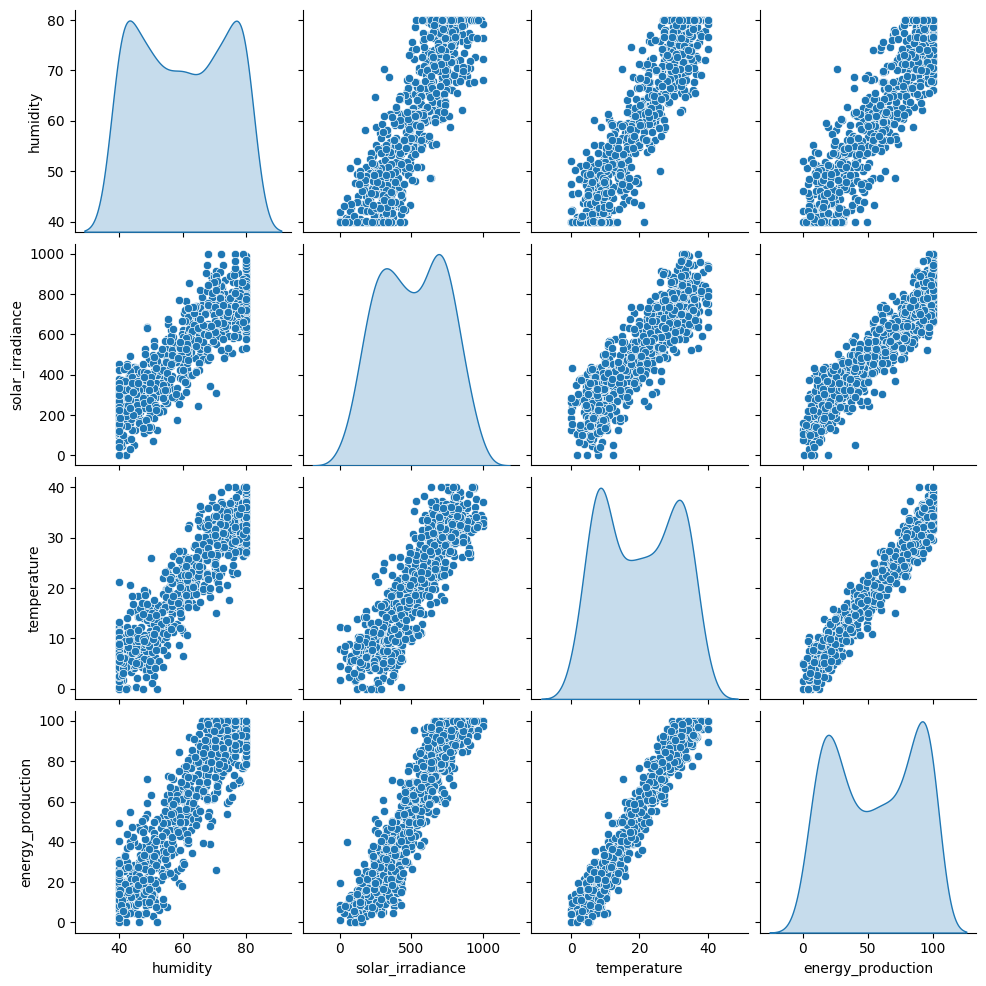

In [3]:
# Correlation matrix to visualize relationships between features
plt.figure(figsize=(8,6))
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Between Features')
plt.show()

# Plot pairwise relationships between features and target variable
sns.pairplot(data, diag_kind='kde')
plt.show()



In [4]:
# Split the data into training and testing sets (80% train, 20% test)
train_size = int(len(data) * 0.8)
train_data = data[:train_size]
test_data = data[train_size:]

# Split target (y) and exogenous variables (X) for both train and test sets
y_train = train_data['energy_production']
X_train = train_data[['humidity', 'temperature', 'solar_irradiance']]

y_test = test_data['energy_production']
X_test = test_data[['humidity', 'temperature', 'solar_irradiance']]


humidity             0.913040
temperature          0.968598
solar_irradiance     0.924483
energy_production    1.000000
Name: energy_production, dtype: float64


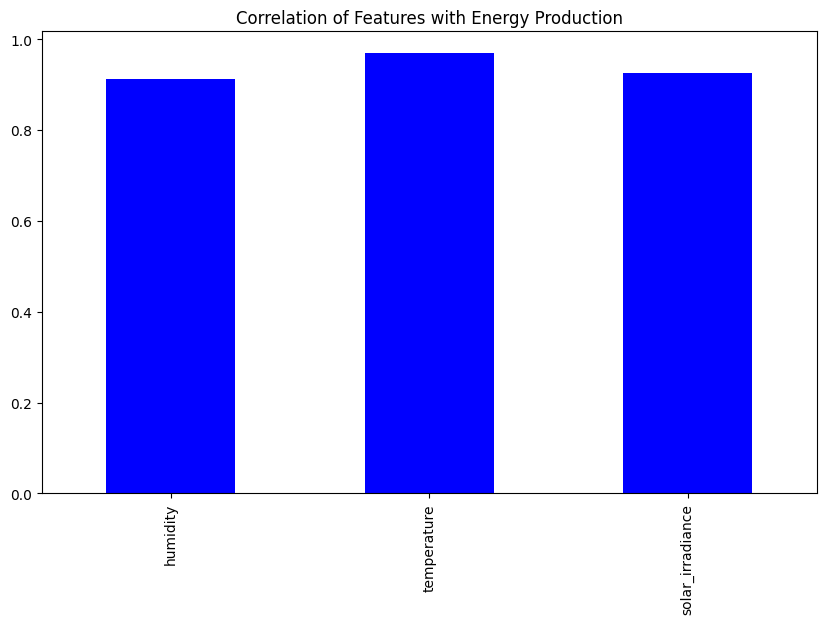

In [5]:
# Correlation of each feature with energy production
print(data[['humidity', 'temperature', 'solar_irradiance', 'energy_production']].corr()['energy_production'])

# Plot the correlation with energy production
correlations = data[['humidity', 'temperature', 'solar_irradiance']].corrwith(data['energy_production'])
correlations.plot(kind='bar', figsize=(10,6), color='blue')
plt.title('Correlation of Features with Energy Production')
plt.show()


In [6]:
# Define the SARIMAX model with exogenous variables
model = SARIMAX(y_train,
                exog=X_train,
                order=(1, 1, 1),  # ARIMA parameters: p, d, q
                seasonal_order=(1, 1, 1, 12),  # Seasonal: P, D, Q, m (assuming monthly seasonality)
                enforce_stationarity=False,
                enforce_invertibility=False)

# Fit the model
sarimax_result = model.fit(disp=False)

# Print model summary
print(sarimax_result.summary())


C:\Users\james\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\james\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                  energy_production   No. Observations:                  584
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1728.344
Date:                            Thu, 26 Sep 2024   AIC                           3472.688
Time:                                    23:34:04   BIC                           3507.268
Sample:                                01-01-2022   HQIC                          3486.194
                                     - 08-07-2023                                         
Covariance Type:                              opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
humidity            -0.4695      0.050     -9.346      0.000      -0.568      -0.371
temperature      

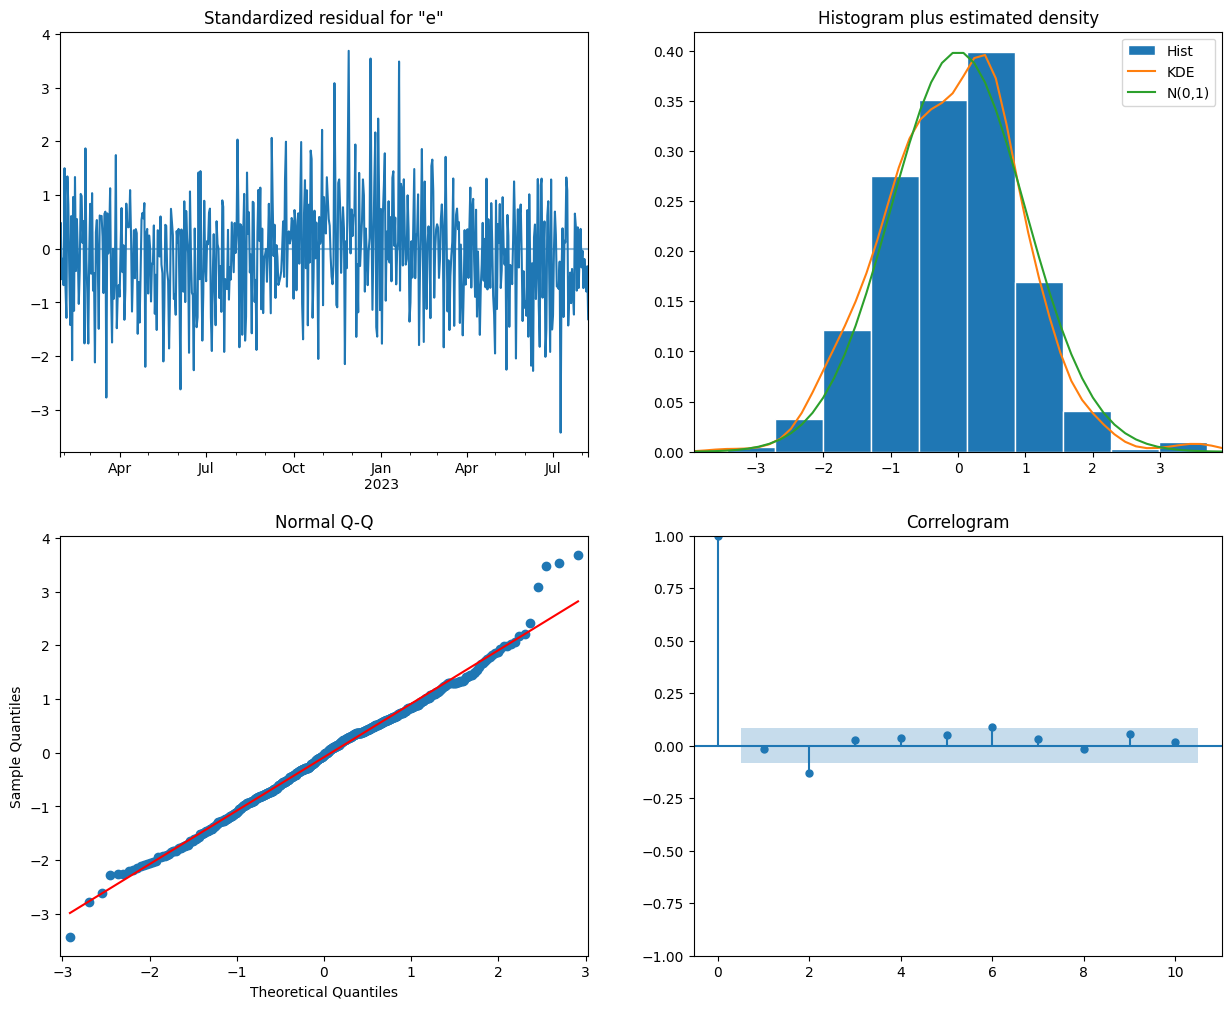

In [7]:
# Plot residual diagnostics
sarimax_result.plot_diagnostics(figsize=(15, 12))
plt.show()


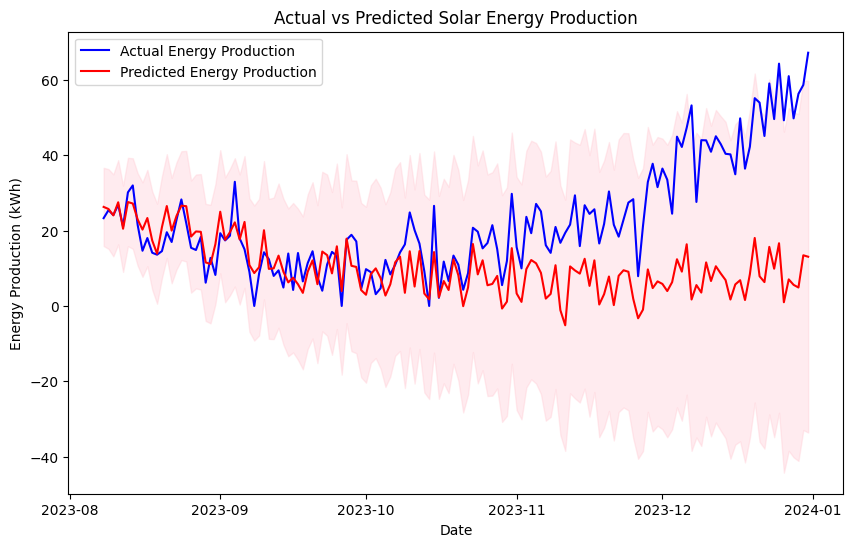

In [8]:
# Forecast the values for the test set (predict using exogenous variables)
forecast = sarimax_result.get_prediction(start=test_data.index[0], end=test_data.index[-1], exog=X_test)

# Get predicted mean values
predicted_values = forecast.predicted_mean

# Plot actual vs predicted energy production
plt.figure(figsize=(10,6))
plt.plot(y_test.index, y_test, label='Actual Energy Production', color='blue')
plt.plot(y_test.index, predicted_values, label='Predicted Energy Production', color='red')
plt.fill_between(predicted_values.index,
                 forecast.conf_int().iloc[:, 0],
                 forecast.conf_int().iloc[:, 1], color='pink', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Energy Production (kWh)')
plt.title('Actual vs Predicted Solar Energy Production')
plt.legend()
plt.show()


RMSE: 20.328218307030625
MAE: 14.25969383582499
R² Score: -0.8547207707976279


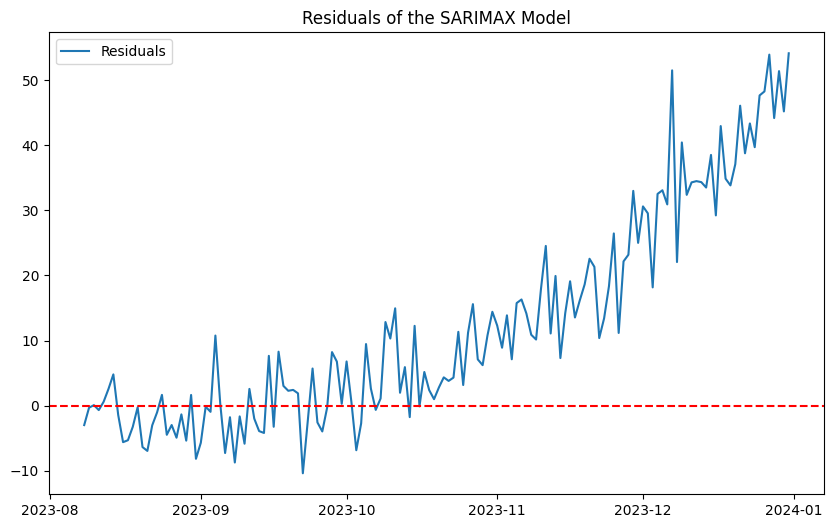

In [9]:
# Calculate RMSE (Root Mean Squared Error)
rmse = math.sqrt(mean_squared_error(y_test, predicted_values))
print(f'RMSE: {rmse}')

# Calculate MAE (Mean Absolute Error)
mae = mean_absolute_error(y_test, predicted_values)
print(f'MAE: {mae}')

# Calculate R² score
r2 = r2_score(y_test, predicted_values)
print(f'R² Score: {r2}')

# Residuals (errors)
residuals = y_test - predicted_values
plt.figure(figsize=(10,6))
plt.plot(residuals, label='Residuals')
plt.axhline(0, linestyle='--', color='red')
plt.title('Residuals of the SARIMAX Model')
plt.legend()
plt.show()


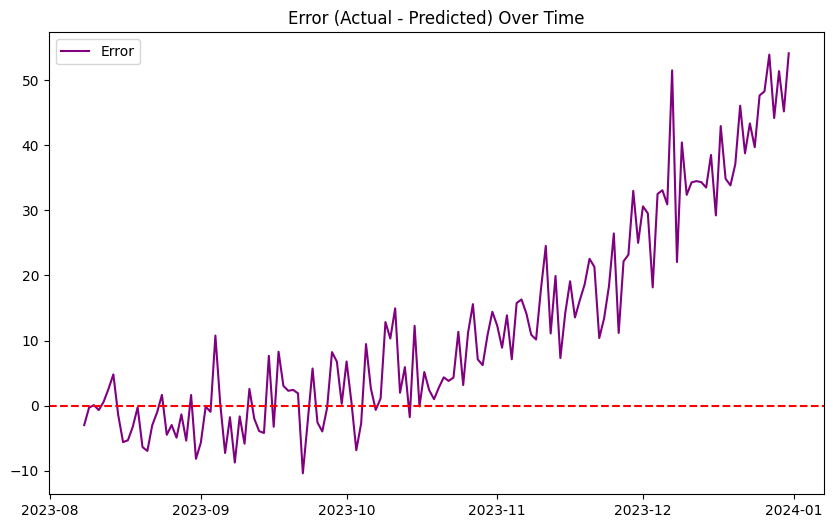

In [10]:
# Plot the error between actual and predicted values
plt.figure(figsize=(10,6))
plt.plot(y_test.index, y_test - predicted_values, label='Error', color='purple')
plt.axhline(0, linestyle='--', color='red')
plt.title('Error (Actual - Predicted) Over Time')
plt.legend()
plt.show()
